### 1/17 追記
AutoEncoderとベイズを比較して、
`predicted image`と`p(P|Q)`の値がほぼ等しい結果が得られた.

それは一体なぜなのか考察してください.


また、この2つの間の違いを定量的に評価することは、発表の上で非常に重要な要素になりそうだと考えられます.
質よりも量で思いついた事、新しい知見などはお互い共有しよう. 何もアウトプットしないことだけは避けてほしいです.


橋爪さんからのアドバイスは以下の3つ.
- `predicted image with binalization`から`original image`に変換出来るか確認する
- `4x4MatrixGenerator.ipynb`のフィルター**A**の値を工夫する. 具体的には、より現実に近いケースを考える. 例として正規分布に従ったノイズ$\epsilon$を加えてみたり... (要考察)
- 実際の風景画や、大きなサイズにおいてこのアルゴリズムを適用してみる. ファミコンのドット絵とか面白そう? もしRGBに対応させるにはどうするか？　要考察

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as iter
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, UpSampling2D

from PIL import Image

%matplotlib inline

In [43]:
class AE():
    def __init__(self, optimizer='rmsprop', loss='mean_squared_error', input_data_path="../4x4matrix.csv"):
        self.p_matrix = np.load("4x4matrix.npz")["p_matrix"]
        self.q_matrix = np.load("4x4matrix.npz")["q_matrix"]
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add( Dense(16, activation = 'relu', input_dim = 9) )
        #self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = 'relu') )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        self.model.compile(optimizer = optimizer,
                           loss = loss,
                           metrics = ['accuracy'])
        
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (self.q_matrix, self.p_matrix))
    
    def predict(self, test_img, threshold):
        preds = self.model.predict(test_img).reshape(4,4)
        preds_binary = preds.copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        print(preds, preds_binary)
        
        if test_img.dtype == 'int64':
            ncols = 5
            fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
            bayes_image = np.empty(16)
            index_when_given_q = np.all(self.q_matrix == test_img.reshape(9,), axis = 1)
            p_given_q = self.p_matrix[index_when_given_q]
            print(p_given_q)
            for col in range(16):
                is_one_counter = 0
                target_list = [p_given_q[row][col] for row in range(p_given_q.shape[0])]
                total_length = len(target_list)
    
                for j in range(total_length):
                    if target_list[j] == 1:
                        is_one_counter += 1
                prob = is_one_counter / total_length
                bayes_image[i] = prob
            axes[3].imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)
            axes[3].set_title("p(P|Q) image based on bayes")
            bayes_image[ bayes_image < thresold ] = 0
            bayes_image[ bayes_image >= thresold ] = 1
            axes[4].imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)
            axes[4].set_title("p(P|Q) image based on bayes with binalization")
            
        elif test_img.dtype == 'float64':
            ncols = 3
            fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        

        axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
        
    def SR(self, input_img, thresold):
        # Preprocessing area
        x, y, z = input_img.shape # dimention x and y
        pad_list = [] # padding count x = 0, y = 1
        for i in [x, y]:
            if i % 3 == 0:
                pad_list.append(0)
            elif i % 3 == 1:
                pad_list.append(2)
            else:
                pad_list.append(1)
        
        temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
        temp[ 0 : x, 0 : y , 0 : z] = input_img
        input_img = temp
        m,n = int(input_img.shape[0] / 3), int(input_img.shape[1] / 3)
        output_img = np.empty((4 * m , 4 * n, 3), dtype='float32')
        print(pad_list[0], pad_list[1])
        
        # SR area
        for dim in [0,1,2]:
            for i, j in iter.product(range(n), range(m)):
                partial_img = input_img.copy()[ 3 * j : 3 * ( j + 1 ), 3 * i : 3 * ( i + 1), dim] 
                if np.all(partial_img < 0.1):
                    partial_img = np.zeros(16)
                else:
                    partial_img = self.model.predict( partial_img.reshape(1,9) )
                output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1), dim] = partial_img.reshape(4,4)
        
        max_val = output_img.max()
        output_img /= max_val
        output_img_binalized = output_img.copy()
        output_img_binalized[output_img_binalized >= thresold] = 1
        output_img_binalized[output_img_binalized < thresold] = 0

        fig, axes = plt.subplots(1,3, figsize = (12,12))
        axes[0].imshow(input_img, cmap = plt.cm.binary)
        axes[0].set_title("input image")
        axes[1].imshow(output_img, cmap = plt.cm.binary)
        axes[1].set_title("output image")
        axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
        axes[2].set_title("output image with biinalization")
        
        return output_img

### ベイズなし版

In [84]:
class AE():
    def __init__(self, optimizer='rmsprop', loss='mean_squared_error', input_data_path="../4x4matrix.csv"):
        self.p_matrix = np.load("4x4matrix.npz")["p_matrix"]
        self.q_matrix = np.load("4x4matrix.npz")["q_matrix"]
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add( Dense(16, activation = 'relu', input_dim = 9) )
        #self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dropout(0.5) )
        self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        self.model.compile(optimizer = optimizer,
                           loss = loss,
                           metrics = ['accuracy'])
        
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (self.q_matrix, self.p_matrix))
    
    def predict(self, test_img, threshold):
        preds = self.model.predict(test_img).reshape(4,4)
        preds_binary = preds.copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        ncols = 3
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
    
    def predict_RGB(self, test_img, threshold):
        preds = np.empty((4,4,3), dtype='float32')
        preds_binary = np.empty((4,4,3), dtype='float32')
        for dim in range(test_img.shape[2]):
            preds[ : , : , dim] = self.model.predict(test_img[ : , : , dim].reshape(1,9)).reshape(4,4)
            preds_binary[ : , : , dim] = preds[ : , : , dim].copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        ncols = 3
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        axes[0].imshow(test_img, cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
        
    def SR(self, input_img, thresold):
        # Preprocessing area
        x, y, z = input_img.shape # dimention x and y
        pad_list = [] # padding count x = 0, y = 1
        for i in [x, y]:
            if i % 3 == 0:
                pad_list.append(0)
            elif i % 3 == 1:
                pad_list.append(2)
            else:
                pad_list.append(1)
        
        temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
        temp[ 0 : x, 0 : y , 0 : z] = input_img
        input_img = temp
        m,n = int(input_img.shape[0] / 3), int(input_img.shape[1] / 3)
        output_img = np.empty((4 * m , 4 * n, 3), dtype='float32')
        print(pad_list[0], pad_list[1])
        
        # SR area
        for dim in [0,1,2]:
            for i, j in iter.product(range(n), range(m)):
                partial_img = input_img.copy()[ 3 * j : 3 * ( j + 1 ), 3 * i : 3 * ( i + 1), dim] 
                if np.all(partial_img < 0.1):
                    partial_img = np.zeros(16)
                else:
                    partial_img = self.model.predict( partial_img.reshape(1,9) )
                output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1), dim] = partial_img.reshape(4,4)
        
        max_val = output_img.max()
        output_img /= max_val
        output_img_binalized = output_img.copy()
        output_img_binalized[output_img_binalized >= thresold] = 1
        output_img_binalized[output_img_binalized < thresold] = 0

        fig, axes = plt.subplots(1,3, figsize = (12,12))
        axes[0].imshow(input_img, cmap = plt.cm.binary)
        axes[0].set_title("input image")
        axes[1].imshow(output_img, cmap = plt.cm.binary)
        axes[1].set_title("output image")
        axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
        axes[2].set_title("output image with biinalization")
        
        return output_img

## CNN版(開発途中)
Generatorをいじる必要あり

In [99]:
class AE():
    def __init__(self, optimizer='rmsprop', loss='mean_squared_error', input_data_path="../4x4matrix.csv"):
        self.p_matrix = np.load("4x4matrix.npz")["p_matrix"].reshape(4,4,1)
        self.q_matrix = np.load("4x4matrix.npz")["q_matrix"].reshape(3,3,1)
        self.optimizer = optimizer
        self.model = Sequential()
        model.add(Conv2D(8, kernel_size=(3, 3),padding ='same', activation='relu', input_shape=(3,3,1)))
        model.add(UpSampling2D((2,2)))
        model.add(Conv2D(16, kernel_size=(3, 3),padding ='same', activation='relu', input_shape=(3,3,1)))
        self.model.compile(optimizer = optimizer,
                           loss = loss,
                           metrics = ['accuracy'])
        
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (self.q_matrix, self.p_matrix))
    
    def predict(self, test_img, threshold):
        preds = self.model.predict(test_img).reshape(4,4)
        preds_binary = preds.copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        ncols = 3
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
    
    def predict_RGB(self, test_img, threshold):
        preds = np.empty((4,4,3), dtype='float32')
        preds_binary = np.empty((4,4,3), dtype='float32')
        for dim in range(test_img.shape[2]):
            preds[ : , : , dim] = self.model.predict(test_img[ : , : , dim].reshape(1,9)).reshape(4,4)
            preds_binary[ : , : , dim] = preds[ : , : , dim].copy()
        preds_binary[preds_binary < threshold] = 0
        preds_binary[preds_binary >= threshold] = 1
        ncols = 3
        fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        axes[0].imshow(test_img, cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
        
    def SR(self, input_img, thresold):
        # Preprocessing area
        x, y, z = input_img.shape # dimention x and y
        pad_list = [] # padding count x = 0, y = 1
        for i in [x, y]:
            if i % 3 == 0:
                pad_list.append(0)
            elif i % 3 == 1:
                pad_list.append(2)
            else:
                pad_list.append(1)
        
        temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
        temp[ 0 : x, 0 : y , 0 : z] = input_img
        input_img = temp
        m,n = int(input_img.shape[0] / 3), int(input_img.shape[1] / 3)
        output_img = np.empty((4 * m , 4 * n, 3), dtype='float32')
        print(pad_list[0], pad_list[1])
        
        # SR area
        for dim in [0,1,2]:
            for i, j in iter.product(range(n), range(m)):
                partial_img = input_img.copy()[ 3 * j : 3 * ( j + 1 ), 3 * i : 3 * ( i + 1), dim] 
                if np.all(partial_img < 0.1):
                    partial_img = np.zeros(16)
                else:
                    partial_img = self.model.predict( partial_img.reshape(1,9) )
                output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1), dim] = partial_img.reshape(4,4)
        
        max_val = output_img.max()
        output_img /= max_val
        output_img_binalized = output_img.copy()
        output_img_binalized[output_img_binalized >= thresold] = 1
        output_img_binalized[output_img_binalized < thresold] = 0

        fig, axes = plt.subplots(1,3, figsize = (12,12))
        axes[0].imshow(input_img, cmap = plt.cm.binary)
        axes[0].set_title("input image")
        axes[1].imshow(output_img, cmap = plt.cm.binary)
        axes[1].set_title("output image")
        axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
        axes[2].set_title("output image with biinalization")
        
        return output_img

In [100]:
autoencoder = AE(optimizer = "rmsprop", loss = keras.losses.binary_crossentropy )

ValueError: cannot reshape array of size 1048576 into shape (4,4,1)

## モデル

In [86]:
autoencoder.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 16)                160       
_________________________________________________________________
dense_26 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
Total params: 976
Trainable params: 976
Non-trainable params: 0
_________________________________________________________________


## 学習

In [89]:
autoencoder.fit(epochs = 20, batch_size=256)

Train on 65536 samples, validate on 65536 samples
Epoch 1/20
65536/65536 [==============================] - 1s 17us/step - loss: 0.6349 - acc: 0.0610 - val_loss: 0.6056 - val_acc: 0.0392
Epoch 2/20
65536/65536 [==============================] - 1s 16us/step - loss: 0.6304 - acc: 0.0467 - val_loss: 0.5984 - val_acc: 0.0291
Epoch 3/20
65536/65536 [==============================] - 1s 16us/step - loss: 0.6270 - acc: 0.0372 - val_loss: 0.5960 - val_acc: 0.0251
Epoch 4/20
65536/65536 [==============================] - 1s 16us/step - loss: 0.6257 - acc: 0.0337 - val_loss: 0.5922 - val_acc: 0.0260
Epoch 5/20
65536/65536 [==============================] - 1s 16us/step - loss: 0.6249 - acc: 0.0334 - val_loss: 0.5916 - val_acc: 0.0338
Epoch 6/20
65536/65536 [==============================] - 1s 16us/step - loss: 0.6238 - acc: 0.0313 - val_loss: 0.5905 - val_acc: 0.0289
Epoch 7/20
65536/65536 [==============================] - 1s 16us/step - loss: 0.6218 - acc: 0.0278 - val_loss: 0.5892 - val_acc

## 予測
### モノクロ版

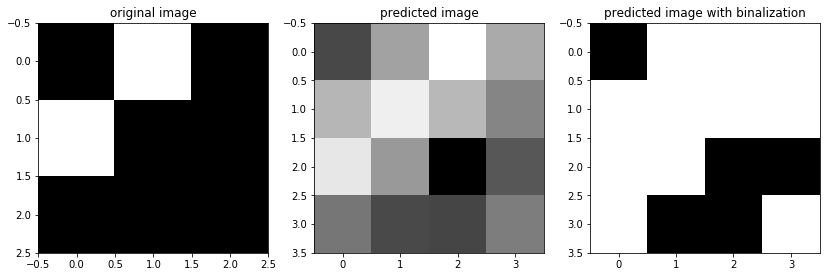

In [90]:
test_img = np.array([[1,0,1,0,1,1,1,1,1]])
threshold = 0.5
autoencoder.predict(test_img, threshold)

### RGB版

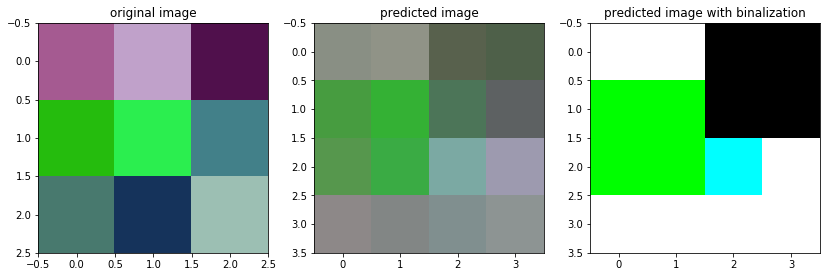

In [92]:
test_img = np.random.rand(3,3,3)
threshold = 0.5
autoencoder.predict_RGB(test_img, threshold)

## より大きな画像で超解像を行う

### 仕様
- `input_img` 
    - (3 x n, 3 x m) dimention
    - from 0 to 1 
    
- `output_img`
    - (4 x n, 4 x m) dimention
    - 0 or 1 binalized
    
- `thresold`

Text(0.5, 1.0, 'output image with biinalization')

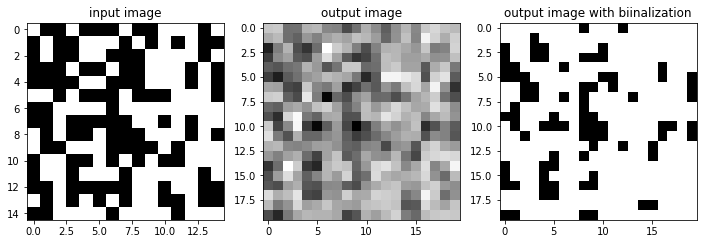

In [93]:
# n = 4
# m = 4
thresold = 0.5

input_img = np.random.randint(0, 2, (15,15), dtype='int8')
x, y = input_img.shape
n, m = int( x / 3 ), int( y / 3 )
output_img = np.empty((4 * n , 4 * m), dtype='float64')

for i, j in iter.product(range(n), range(m)):
    partial_img = input_img.copy()[ 3 * j : 3 * (j + 1), 3 * i : 3 * ( i + 1)] 
    partial_img = autoencoder.model.predict(partial_img.reshape(1,9))
    output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1)] = partial_img.reshape(4,4)

output_img_binalized = output_img.copy()
output_img_binalized[output_img_binalized >= thresold] = 1
output_img_binalized[output_img_binalized < thresold] = 0

fig, axes = plt.subplots(1,3, figsize = (12,12))
axes[0].imshow(input_img, cmap = plt.cm.binary)
axes[0].set_title("input image")
axes[1].imshow(output_img, cmap = plt.cm.binary)
axes[1].set_title("output image")
axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
axes[2].set_title("output image with biinalization")

## メソッド版
- `img1.jpeg` : 理科大マーク
- `img2.jpg` : 激重
- `img3.jpg` : 葛飾
- `img4.jpg` : ロックマン

0 0
[[[0.63371676 0.62509054 0.61167496]
  [0.6597637  0.66972864 0.67772645]
  [0.3691434  0.4119335  0.46853682]
  ...
  [0.6622255  0.6698771  0.6764567 ]
  [0.37616885 0.41680768 0.46459222]
  [0.361589   0.383591   0.41065845]]

 [[0.71633905 0.71354157 0.70505416]
  [0.7929437  0.78753066 0.78908044]
  [0.42193696 0.42545786 0.45703992]
  ...
  [0.7915987  0.7871322  0.7890929 ]
  [0.4190792  0.42820528 0.45628828]
  [0.3656677  0.3796478  0.39933398]]

 [[0.70604813 0.7226484  0.74018425]
  [0.84688246 0.8415467  0.8383966 ]
  [0.8249887  0.7971604  0.7727898 ]
  ...
  [0.84520155 0.8415646  0.8391605 ]
  [0.8183927  0.79526824 0.77516085]
  [0.6997958  0.6977711  0.6930284 ]]

 ...

 [[0.3436546  0.38744843 0.38060206]
  [0.34653816 0.37460992 0.34219074]
  [0.4295034  0.440018   0.42732906]
  ...
  [0.692208   0.69326115 0.6111092 ]
  [0.4349995  0.46159908 0.40200847]
  [0.32429525 0.36458546 0.26913345]]

 [[0.40502638 0.42849585 0.27042872]
  [0.39559287 0.3934693  0.323007

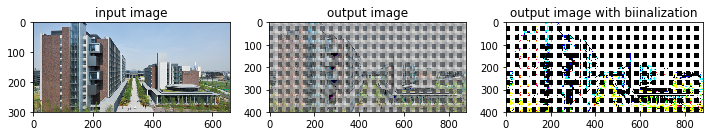

In [94]:
input_img = np.random.randint(0,2, (15,15), dtype='int16')
input_img = np.array(Image.open("img/img3.jpg"), "f") / 255
output_img = autoencoder.SR(input_img, 0.5)
print(output_img)
output_img = Image.fromarray(np.uint8(255 * output_img))
output_img.save('img/img4_output.jpg', quality=95)

1 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


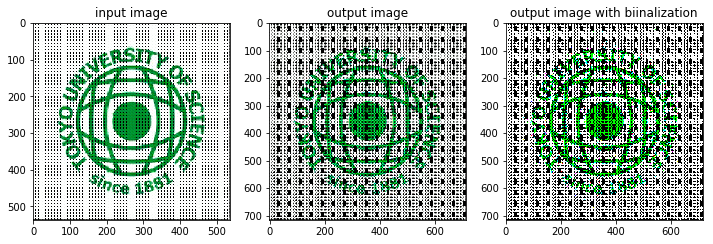

In [413]:
output_img = autoencoder.SR(output_img, 0.5)

## ベイズルールによる結果

In [53]:
index_when_given_q = np.all(autoencoder.q_matrix == test_img, axis = 1)
p_given_q = autoencoder.p_matrix[index_when_given_q]

/Users/shimotori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


AxisError: axis 1 is out of bounds for array of dimension 0

NameError: name 'p_given_q' is not defined

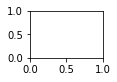

In [54]:
n = 16
for i in range(n):
    ax = plt.subplot(4, 4, i+1)
    plt.hist([p_given_q[j][i] for j in range(p_given_q.shape[0])], bins = [0,1,2])

In [9]:
n = 16
bayes_image = np.empty(n)
for i in range(n):
    is_one_counter = 0
    target_list = [p_given_q[j][i] for j in range(p_given_q.shape[0])]
    total_length = len(target_list)
    
    for j in range(total_length):
        if target_list[j] == 1:
            is_one_counter += 1
    prob = is_one_counter / total_length
    bayes_image[i] = prob

In [10]:
bayes_image

array([0.2654321 , 0.39969136, 0.85339506, 0.6867284 , 0.06018519,
       0.42283951, 0.92592593, 0.16820988, 0.25154321, 0.74845679,
       0.05092593, 0.13117284, 0.85802469, 0.3117284 , 0.13580247,
       0.41049383])

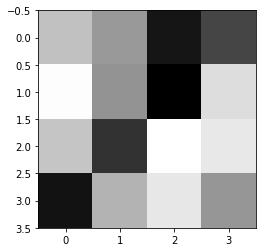

In [11]:
plt.imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)

In [198]:
test = np.random.randint(0,2,(6,4))
x, y = test.shape
xy = 0 #count x = 0, y = 1
pad_list = []
for i in [x, y]:
    if i % 3 == 0:
        pad_list.append(0)
    elif i % 3 == 1:
        pad_list.append(2)
    else:
        pad_list.append(1)
    xy += 1

test_ = np.zeros((x + pad_list[0], y + pad_list[1]))
print(test_.shape)

(6, 6)


In [84]:
np.arange(6).reshape(1,2,3)

array([[[0, 1, 2],
        [3, 4, 5]]])

In [87]:
np.array(Image.open("img/img4.jpg"), "f").shape

(320, 320, 3)